## IMPLEMENT GAN WITH TF.SLIM

In [1]:
import time
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
print ("TENSORFLOW VERSION IS %s" % (tf.__version__))

TENSORFLOW VERSION IS 1.0.1


## TO SHORTEN THE CODE

In [2]:
tf_tni   = tf.truncated_normal_initializer
tf_rni   = tf.random_normal_initializer
tf_ci    = tf.constant_initializer
slim_fc  = slim.fully_connected
slim_bn  = slim.batch_norm
slim_ct  = slim.conv2d_transpose
slim_c   = slim.conv2d
tf_relu  = tf.nn.relu
tf_tanh  = tf.nn.tanh
tf_sigm  = tf.nn.sigmoid
tf_sigce = tf.nn.sigmoid_cross_entropy_with_logits

## UTILS

In [3]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 1))
    for idx, image in enumerate(images):
        image = image.reshape(28, 28)
        i = idx % size[1]
        j = idx // size[1]        
        img[j*h:j*h+h, i*w:i*w+w, 0] = image
    return img

## MAKE DCGAN CLASS

In [4]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)
    
class DCGAN(object):
    def __init__(self, sess, config):
        self.sess        = sess
        self.epoch       = config.epoch
        self.learning_rate  = config.learning_rate
        self.beta1       = config.beta1
        self.train_size  = config.train_size
        self.batch_size  = config.batch_size
        self.c_dim       = config.c_dim
        self.image_size  = 28
        self.sample_size = 64
        self.z_dim       = 100
        self.gf_dim      = 64
        self.df_dim      = 64
        # INITIALIZE PARAMETERS
        self.conv_init_params  = tf_tni(stddev=0.02)
        self.fully_init_params = tf_rni(stddev=0.02)
        self.bias_init_params  = tf_ci(0.0)
        self.bn_init_params    = {'beta': tf_ci(0.), 'gamma': tf_rni(1., 0.02)}
        # BUILD MODEL
        self.build_model()
    
    def generator(self, z, is_training=True):
        bn_params = {'is_training': is_training, 'decay': 0.9, 'epsilon': 1e-5
                     , 'param_initializers': self.bn_init_params
                     , 'updates_collections': None}
        s, s4 = self.image_size, int(self.image_size/4)
        with tf.variable_scope('G') as scope:
            z = slim_fc(z, self.gf_dim*2*s4*s4, activation_fn = None
                        , weights_initializer = self.fully_init_params
                        , biases_initializer = self.bias_init_params, scope = 'lin0')
            d0 = tf.reshape(z, [-1, s4, s4, self.gf_dim*2])
            d0 = slim_bn(d0, decay=0.9, param_initializers = self.bn_init_params
                         , activation_fn = tf.nn.relu, scope = 'lin1')
            d1 = slim_ct(d0, self.gf_dim*1, [5, 5], stride = 2, activation_fn = tf_relu
                         , weights_initializer = self.conv_init_params
                         , biases_initializer = self.bias_init_params
                         , normalizer_fn = slim.batch_norm
                         , normalizer_params = bn_params, scope = 'dconv1')
            gen = slim_ct(d1, self.c_dim, [5, 5], stride = 2, activation_fn = tf_tanh
                          ,weights_initializer = self.conv_init_params
                          , biases_initializer = self.bias_init_params, scope = 'dconv2')
        return gen
    
    def discriminator(self, image, is_training=True, reuse=False):
        bn_params = {'is_training': is_training, 'decay': 0.9, 'epsilon': 1e-5
                     , 'param_initializers': self.bn_init_params
                     , 'updates_collections': None}
        with tf.variable_scope('D') as scope:
            if reuse:
                scope.reuse_variables()
            e0 = slim_c(image, self.df_dim, [5, 5], stride = 2, activation_fn = lrelu
                        , weights_initializer = self.conv_init_params
                        , biases_initializer = self.bias_init_params, scope='conv0')
            e1 = slim_c(e0, self.df_dim*2, [5, 5], stride = 2, activation_fn = lrelu
                        , weights_initializer = self.conv_init_params
                        , biases_initializer = self.bias_init_params
                        , normalizer_fn = slim_bn, normalizer_params = bn_params, scope='conv1')
            e2 = slim_fc(tf.reshape(e1, [-1, 1]), 1, activation_fn=None
                         , weights_initializer = self.fully_init_params
                         , biases_initializer = self.bias_init_params, scope='lin2')
        return tf.nn.sigmoid(e2), e2
    
    def build_model(self):
        # PLACE HOLDERS
        _shape = [self.batch_size] + [self.image_size, self.image_size, self.c_dim]
        self.images = tf.placeholder(tf.float32, _shape)
        self.z = tf.placeholder(tf.float32, [None, self.z_dim])
        self.is_training = tf.placeholder(tf.bool)
        # GENERATOR
        self.G = self.generator(self.z, self.is_training)
        # DISCRIMINATOR
        d_real, d_real_logits = self.discriminator(self.images, self.is_training, reuse=False)
        d_gen, d_gen_logits   = self.discriminator(self.G, self.is_training, reuse=True)
        # LOSS (sigmoid_cross_entropy_with_logits)
        self.d_loss = tf.reduce_mean(tf_sigce(logits=d_real_logits, labels=tf.ones_like(d_real))) \
                        + tf.reduce_mean(tf_sigce(logits=d_gen_logits, labels=tf.zeros_like(d_gen)))
        self.g_loss = tf.reduce_mean(tf_sigce(logits=d_gen_logits, labels=tf.ones_like(d_gen)))
        # GET VARIABLES
        t_vars = tf.trainable_variables()
        self.g_vars = [var for var in t_vars if 'G/' in var.name]
        self.d_vars = [var for var in t_vars if 'D/' in var.name]
        # SET OPTIMIZERS
        adam = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1)
        self.g_optim = adam.minimize(self.g_loss, var_list=self.g_vars)
        self.d_optim = adam.minimize(self.d_loss, var_list=self.d_vars)
        print ("BUILD MODEL")
        print ("GENERATOR PARAMETERS")
        for i in range(len(self.g_vars)):
            print (" [%d] %s Shape: %s" % (i, self.g_vars[i].name
                                 , self.g_vars[i].get_shape().as_list()))
        print ("DISCRIMINATOR PARAMETERS")
        for i in range(len(self.d_vars)):
            print (" [%d] [%s] Shape: %s" % (i, self.d_vars[i].name
                                 , self.d_vars[i].get_shape().as_list()))
    
    def train(self):
        print ("START TRAINING.")
        # LOAD MNIST DATA AND CONCATENATE TRAIN AND TEST IMAGES
        np.random.seed(0)
        mnist = input_data.read_data_sets('data/', one_hot=True)
        trX   = mnist.train.images.reshape([-1, 28, 28, 1])
        teX   = mnist.test.images.reshape([-1, 28, 28, 1])
        data  = np.concatenate((trX, teX), axis=0).astype(np.float32)
        data  = 2*data - 1
        np.random.shuffle(data)
        print ("SHAPE OF DATA IS %s" % (data.shape,))
        # INITIALIZE
        init = tf.global_variables_initializer()
        self.sess.run(init)
        # WE FIX RANDOM VECTOR, THIS IS ONLY FOR TESTING
        sample_z = np.random.uniform(-1, 1, size=(self.sample_size, self.z_dim))
        # PLOT REFERENCE SAMPLE IMAGES
        sample_images = data[0:self.sample_size]
        img_merged = merge(sample_images[0:self.sample_size], [8, 8])
        plt.imshow(img_merged[:, :, 0], cmap='gray')
        plt.colorbar()
        plt.title('Reference Image')
        plt.show()
    
        start_time = time.time()
        g_losses = []
        d_losses = []
        for epoch in xrange(0, self.epoch):
            np.random.seed(epoch)
            np.random.shuffle(data)
            batch_idxs = min(len(data), self.train_size) // self.batch_size
            
            for idx in xrange(0, batch_idxs):
                # GET BATCH IMAGES
                batch_images = data[xrange(idx*self.batch_size, (idx+1)*self.batch_size)]
                # GENERATE RANDOM VECTOR Z
                z_size = [self.batch_size, self.z_dim]
                batch_z = np.random.uniform(-1, 1, z_size).astype(np.float32)
                # UPDATE D AND G
                feeds = {self.images: batch_images, self.z: batch_z, self.is_training: True}
                _, _ = self.sess.run([self.d_optim, self.g_optim], feed_dict=feeds)
                # GET G AND D LOSS
                g_loss, d_loss = self.sess.run([self.g_loss, self.d_loss], feed_dict=feeds)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                # PRINT
                if (idx % int(batch_idxs/5)) == 0:
                    print("Epoch: [%2d] [%4d/%4d] time: %5.2fs, d: %.5f, g: %.5f" 
                          % (epoch, idx, batch_idxs, time.time()-start_time, d_loss, g_loss))

            # PLOT EVERY EPOCH 
            feeds = {self.z: sample_z, self.is_training: False}
            sG = self.sess.run([self.G], feed_dict=feeds)
            concatIm = np.concatenate(sG)
            img_merged = merge(concatIm, [8, 8])
            plt.imshow(img_merged[:, :, 0], cmap='gray')
            plt.colorbar()
            plt.title('Sampled Images (Epoch:' + str(epoch) + ')')
            plt.show()
            plt.figure(figsize=(5, 2))
            plt.plot(g_losses)
            plt.title('Generator Loss')
            plt.show()
            plt.figure(figsize=(5, 2))
            plt.plot(d_losses)
            plt.title('Discriminator Loss')
            plt.show()
print ("DCGAN CLASS READY")

DCGAN CLASS READY


## DCGAN

In [5]:
sess  = tf.Session()
flags = tf.app.flags
flags.DEFINE_integer("epoch",         10,      "Epochs")
flags.DEFINE_float(  "learning_rate", 0.0001,  "Learning Rate [0.0002]")
flags.DEFINE_float(  "beta1",         0.5,     "Momentum [0.5]")
flags.DEFINE_integer("train_size",    np.inf,  "Maximum Train Size")
flags.DEFINE_integer("batch_size",    32,      "Batch Size [64]")
flags.DEFINE_integer("c_dim",         1,       "Channel")
FLAGS = flags.FLAGS
dcgan = DCGAN(sess, FLAGS)
print ("DCGAN READY")

BUILD MODEL
GENERATOR PARAMETERS
 [0] G/lin0/weights:0 Shape: [100, 6272]
 [1] G/lin0/biases:0 Shape: [6272]
 [2] G/lin1/beta:0 Shape: [128]
 [3] G/dconv1/weights:0 Shape: [5, 5, 64, 128]
 [4] G/dconv1/BatchNorm/beta:0 Shape: [64]
 [5] G/dconv2/weights:0 Shape: [5, 5, 1, 64]
 [6] G/dconv2/biases:0 Shape: [1]
DISCRIMINATOR PARAMETERS
 [0] [D/conv0/weights:0] Shape: [5, 5, 1, 64]
 [1] [D/conv0/biases:0] Shape: [64]
 [2] [D/conv1/weights:0] Shape: [5, 5, 64, 128]
 [3] [D/conv1/BatchNorm/beta:0] Shape: [128]
 [4] [D/lin2/weights:0] Shape: [1, 1]
 [5] [D/lin2/biases:0] Shape: [1]
DCGAN READY


## TRAIN

START TRAINING.
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
SHAPE OF DATA IS (65000, 28, 28, 1)


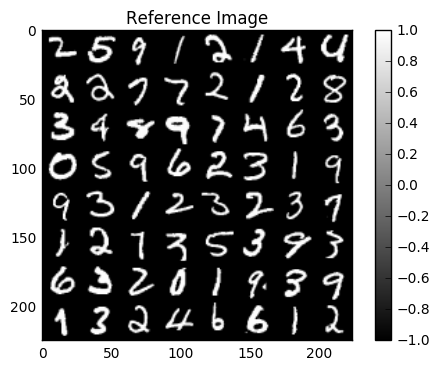

Epoch: [ 0] [   0/2031] time:  0.49s, d: 1.38659, g: 0.69690
Epoch: [ 0] [ 406/2031] time:  9.01s, d: 1.38525, g: 0.69410
Epoch: [ 0] [ 812/2031] time: 17.46s, d: 1.38596, g: 0.69328
Epoch: [ 0] [1218/2031] time: 25.94s, d: 1.38589, g: 0.69368
Epoch: [ 0] [1624/2031] time: 34.53s, d: 1.38604, g: 0.69339
Epoch: [ 0] [2030/2031] time: 42.96s, d: 1.38599, g: 0.69330


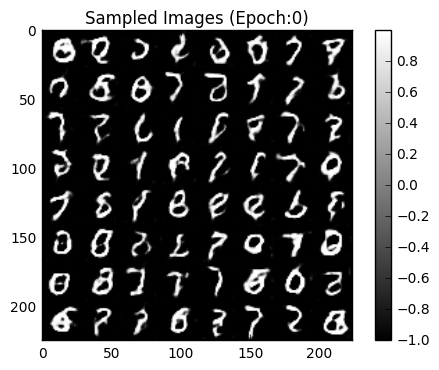

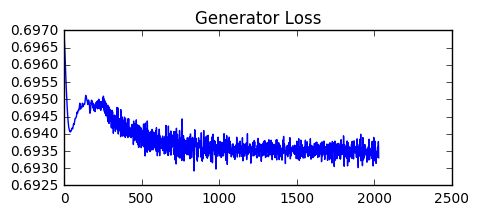

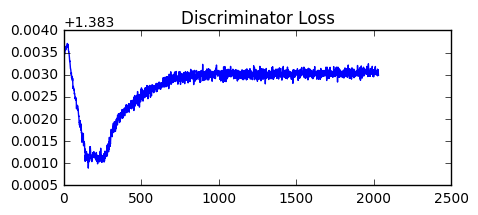

Epoch: [ 1] [   0/2031] time: 43.44s, d: 1.38600, g: 0.69327
Epoch: [ 1] [ 406/2031] time: 51.83s, d: 1.38612, g: 0.69382
Epoch: [ 1] [ 812/2031] time: 60.25s, d: 1.38615, g: 0.69357
Epoch: [ 1] [1218/2031] time: 68.68s, d: 1.38612, g: 0.69322
Epoch: [ 1] [1624/2031] time: 77.18s, d: 1.38613, g: 0.69349
Epoch: [ 1] [2030/2031] time: 85.59s, d: 1.38622, g: 0.69357


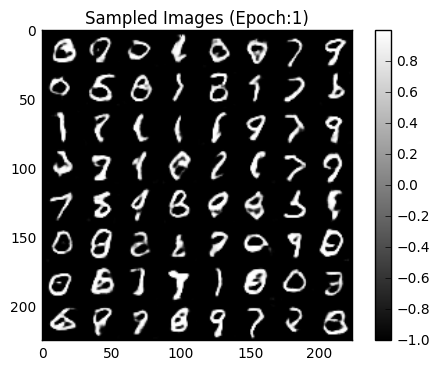

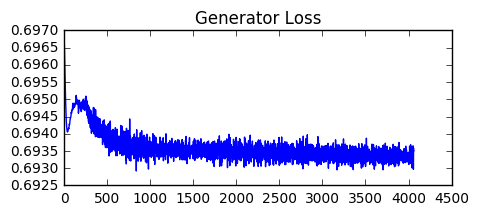

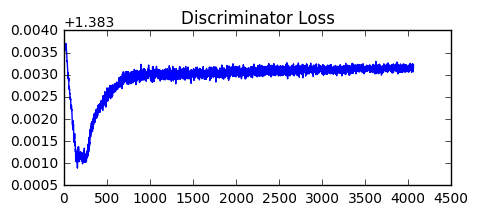

Epoch: [ 2] [   0/2031] time: 86.05s, d: 1.38614, g: 0.69338
Epoch: [ 2] [ 406/2031] time: 94.48s, d: 1.38606, g: 0.69317
Epoch: [ 2] [ 812/2031] time: 102.94s, d: 1.38611, g: 0.69327
Epoch: [ 2] [1218/2031] time: 111.52s, d: 1.38620, g: 0.69348
Epoch: [ 2] [1624/2031] time: 119.91s, d: 1.38621, g: 0.69314
Epoch: [ 2] [2030/2031] time: 128.34s, d: 1.38614, g: 0.69333


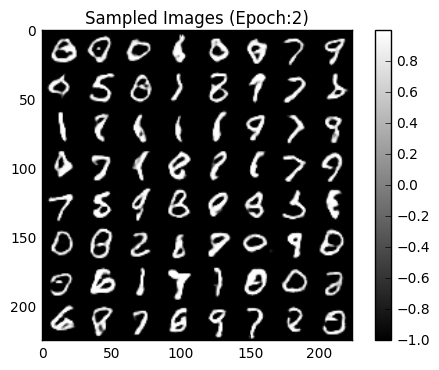

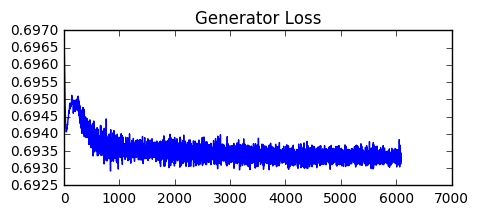

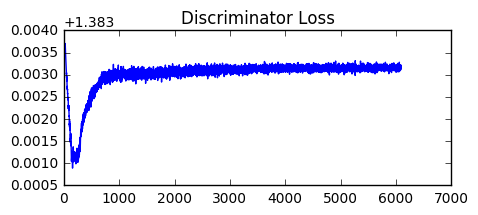

Epoch: [ 3] [   0/2031] time: 128.80s, d: 1.38613, g: 0.69348
Epoch: [ 3] [ 406/2031] time: 137.20s, d: 1.38624, g: 0.69330
Epoch: [ 3] [ 812/2031] time: 145.53s, d: 1.38618, g: 0.69332
Epoch: [ 3] [1218/2031] time: 153.92s, d: 1.38613, g: 0.69328
Epoch: [ 3] [1624/2031] time: 162.34s, d: 1.38617, g: 0.69347
Epoch: [ 3] [2030/2031] time: 170.79s, d: 1.38614, g: 0.69323


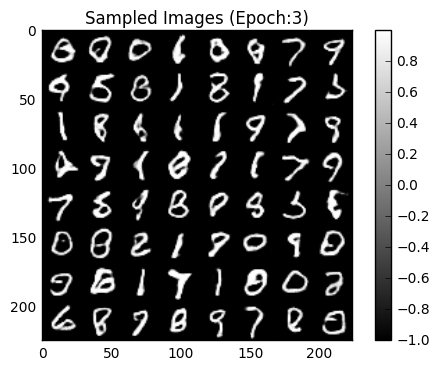

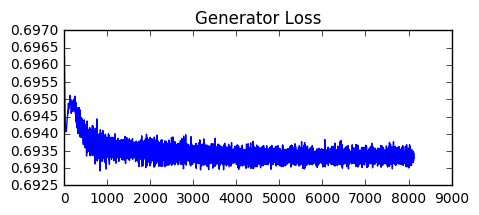

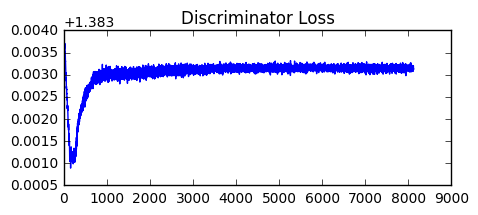

Epoch: [ 4] [   0/2031] time: 171.27s, d: 1.38617, g: 0.69326
Epoch: [ 4] [ 406/2031] time: 179.69s, d: 1.38613, g: 0.69349
Epoch: [ 4] [ 812/2031] time: 188.07s, d: 1.38615, g: 0.69340
Epoch: [ 4] [1218/2031] time: 196.55s, d: 1.38620, g: 0.69319
Epoch: [ 4] [1624/2031] time: 204.97s, d: 1.38615, g: 0.69324
Epoch: [ 4] [2030/2031] time: 213.39s, d: 1.38605, g: 0.69337


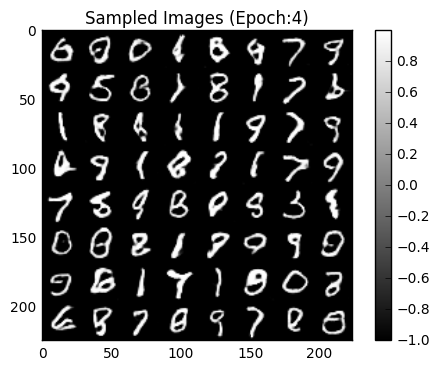

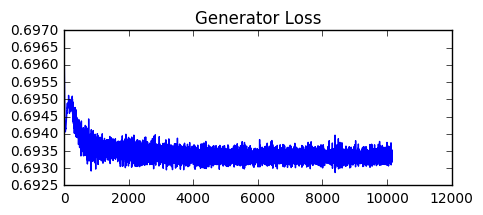

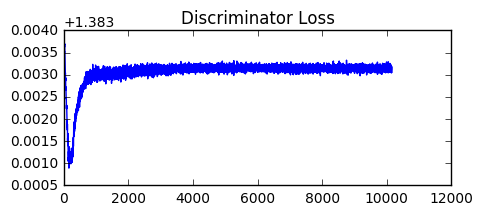

Epoch: [ 5] [   0/2031] time: 213.94s, d: 1.38606, g: 0.69321
Epoch: [ 5] [ 406/2031] time: 222.42s, d: 1.38609, g: 0.69339
Epoch: [ 5] [ 812/2031] time: 230.88s, d: 1.38607, g: 0.69335
Epoch: [ 5] [1218/2031] time: 239.40s, d: 1.38612, g: 0.69360
Epoch: [ 5] [1624/2031] time: 247.83s, d: 1.38606, g: 0.69338
Epoch: [ 5] [2030/2031] time: 256.26s, d: 1.38604, g: 0.69361


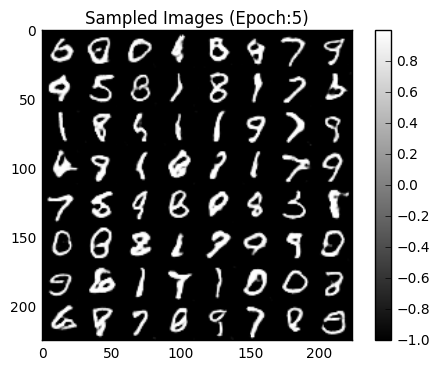

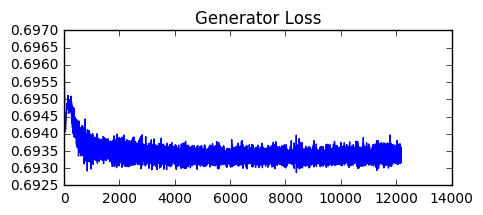

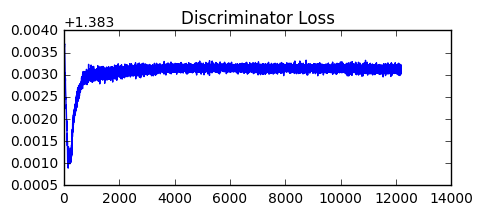

Epoch: [ 6] [   0/2031] time: 256.74s, d: 1.38621, g: 0.69329
Epoch: [ 6] [ 406/2031] time: 265.32s, d: 1.38612, g: 0.69329
Epoch: [ 6] [ 812/2031] time: 273.75s, d: 1.38617, g: 0.69329
Epoch: [ 6] [1218/2031] time: 282.15s, d: 1.38619, g: 0.69321
Epoch: [ 6] [1624/2031] time: 290.66s, d: 1.38608, g: 0.69349
Epoch: [ 6] [2030/2031] time: 299.11s, d: 1.38610, g: 0.69328


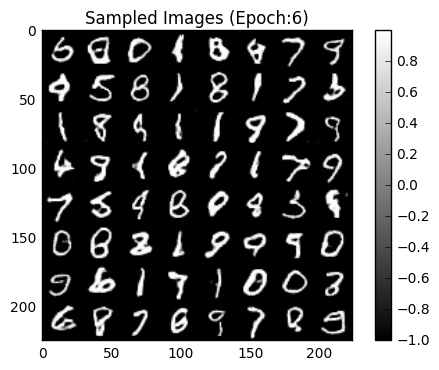

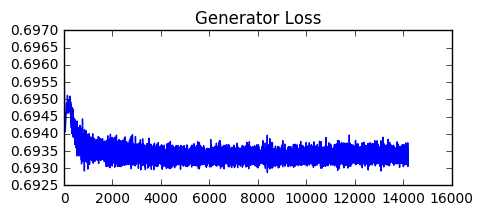

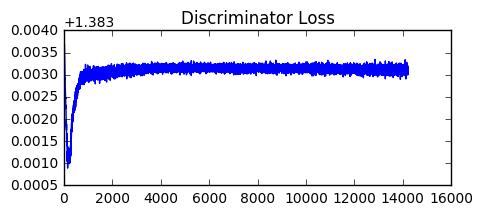

Epoch: [ 7] [   0/2031] time: 299.59s, d: 1.38612, g: 0.69327
Epoch: [ 7] [ 406/2031] time: 307.99s, d: 1.38599, g: 0.69336
Epoch: [ 7] [ 812/2031] time: 316.39s, d: 1.38609, g: 0.69347
Epoch: [ 7] [1218/2031] time: 324.89s, d: 1.38599, g: 0.69345
Epoch: [ 7] [1624/2031] time: 333.26s, d: 1.38619, g: 0.69351
Epoch: [ 7] [2030/2031] time: 341.60s, d: 1.38614, g: 0.69329


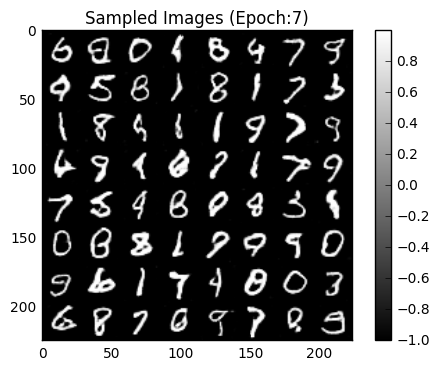

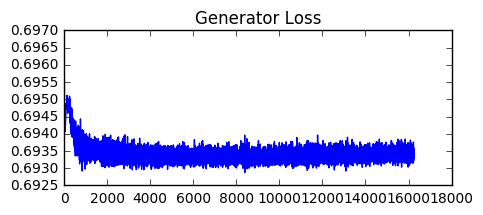

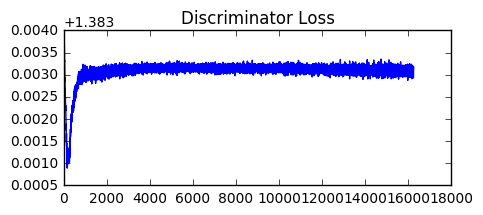

Epoch: [ 8] [   0/2031] time: 342.09s, d: 1.38607, g: 0.69339
Epoch: [ 8] [ 406/2031] time: 350.48s, d: 1.38597, g: 0.69345
Epoch: [ 8] [ 812/2031] time: 358.95s, d: 1.38614, g: 0.69337
Epoch: [ 8] [1218/2031] time: 367.41s, d: 1.38609, g: 0.69336
Epoch: [ 8] [1624/2031] time: 375.94s, d: 1.38611, g: 0.69334
Epoch: [ 8] [2030/2031] time: 384.40s, d: 1.38602, g: 0.69333


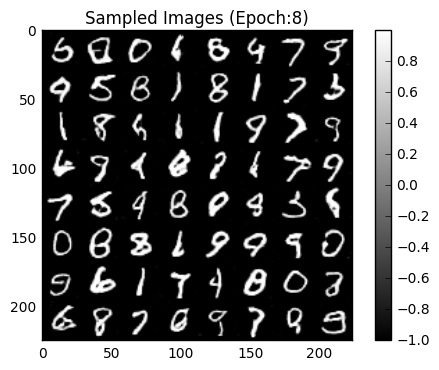

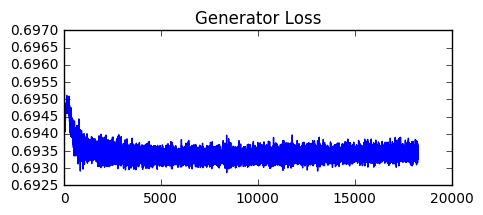

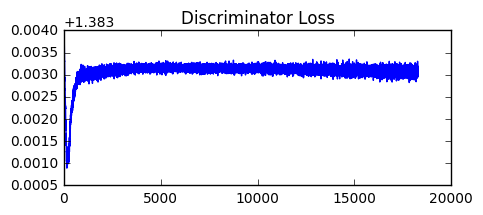

Epoch: [ 9] [   0/2031] time: 384.86s, d: 1.38601, g: 0.69340
Epoch: [ 9] [ 406/2031] time: 393.31s, d: 1.38601, g: 0.69349
Epoch: [ 9] [ 812/2031] time: 401.85s, d: 1.38601, g: 0.69348
Epoch: [ 9] [1218/2031] time: 410.29s, d: 1.38603, g: 0.69354
Epoch: [ 9] [1624/2031] time: 418.73s, d: 1.38600, g: 0.69321
Epoch: [ 9] [2030/2031] time: 427.24s, d: 1.38599, g: 0.69343


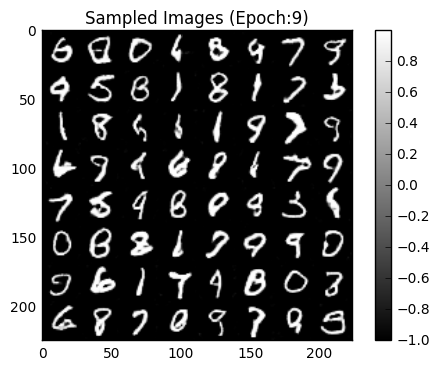

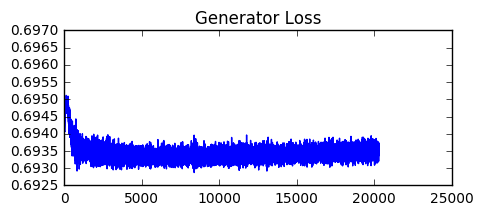

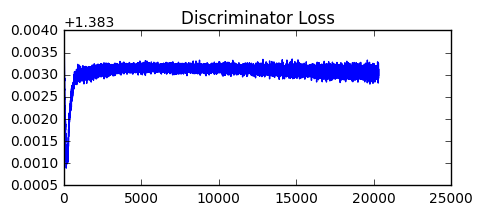

TRAIN FINISHED.


In [6]:
dcgan.train()
print ("TRAIN FINISHED.")